In [1]:
!pip install -r requirements.txt

In [2]:
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_20062/343306588.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=186el6hPe81eA1YkS_2PU4S4ZbYzhNPjr' -O dataset.csv

# 1. Exploratory Data Analysis

In [5]:
dataset = pd.read_csv('dataset.csv')

In [6]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:>

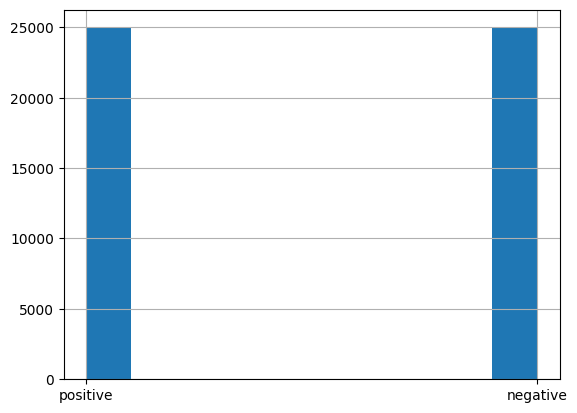

In [7]:
dataset['sentiment'].hist()

We are mostly interested in negative comments, thus we assign 1 label to them.

In [8]:
dataset['sentiment'] = dataset['sentiment'].map({'positive': 0,
                                                 'negative': 1})
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [9]:
reviews = dataset['review'].values.tolist()
reviews[:10]

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

# 2. Data preprocessing
## 2.1. Remove structures without semantic meaning

In [10]:
import re

In [11]:
reviews = [re.sub("<.+?>", "", rev) for rev in reviews]
reviews[:2]

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows w

In [12]:
reviews = [re.sub('\S*\d+\S*', "", rev) for rev in reviews]
reviews[:2]

["One of the other reviewers has mentioned that after watching just  Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

## 2.2. Remove capital letters

In [13]:
reviews = [rev.lower() for rev in reviews]
reviews[:2]

["one of the other reviewers has mentioned that after watching just  oz episode you'll be hooked. they are right, as this is exactly what happened with me.the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.i would say the main appeal of the show is due to the fact that it goes where other shows wo

## 2.3. Tokenization

In [14]:
reviews = [nltk.word_tokenize(rev) for rev in reviews]
reviews[:2]

[['one',
  'of',
  'the',
  'other',
  'reviewers',
  'has',
  'mentioned',
  'that',
  'after',
  'watching',
  'just',
  'oz',
  'episode',
  'you',
  "'ll",
  'be',
  'hooked',
  '.',
  'they',
  'are',
  'right',
  ',',
  'as',
  'this',
  'is',
  'exactly',
  'what',
  'happened',
  'with',
  'me.the',
  'first',
  'thing',
  'that',
  'struck',
  'me',
  'about',
  'oz',
  'was',
  'its',
  'brutality',
  'and',
  'unflinching',
  'scenes',
  'of',
  'violence',
  ',',
  'which',
  'set',
  'in',
  'right',
  'from',
  'the',
  'word',
  'go',
  '.',
  'trust',
  'me',
  ',',
  'this',
  'is',
  'not',
  'a',
  'show',
  'for',
  'the',
  'faint',
  'hearted',
  'or',
  'timid',
  '.',
  'this',
  'show',
  'pulls',
  'no',
  'punches',
  'with',
  'regards',
  'to',
  'drugs',
  ',',
  'sex',
  'or',
  'violence',
  '.',
  'its',
  'is',
  'hardcore',
  ',',
  'in',
  'the',
  'classic',
  'use',
  'of',
  'the',
  'word.it',
  'is',
  'called',
  'oz',
  'as',
  'that',
  'is',

## 2.4. Stopwords removal

In [15]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/waldemar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
stopwords.extend([
    "'ll",
    "'re",
    "'m"
])

In [17]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
reviews = [[token for token in rev if token not in stopwords] for rev in reviews]
reviews[:2]

[['one',
  'reviewers',
  'mentioned',
  'watching',
  'oz',
  'episode',
  'hooked',
  '.',
  'right',
  ',',
  'exactly',
  'happened',
  'me.the',
  'first',
  'thing',
  'struck',
  'oz',
  'brutality',
  'unflinching',
  'scenes',
  'violence',
  ',',
  'set',
  'right',
  'word',
  'go',
  '.',
  'trust',
  ',',
  'show',
  'faint',
  'hearted',
  'timid',
  '.',
  'show',
  'pulls',
  'punches',
  'regards',
  'drugs',
  ',',
  'sex',
  'violence',
  '.',
  'hardcore',
  ',',
  'classic',
  'use',
  'word.it',
  'called',
  'oz',
  'nickname',
  'given',
  'oswald',
  'maximum',
  'security',
  'state',
  'penitentary',
  '.',
  'focuses',
  'mainly',
  'emerald',
  'city',
  ',',
  'experimental',
  'section',
  'prison',
  'cells',
  'glass',
  'fronts',
  'face',
  'inwards',
  ',',
  'privacy',
  'high',
  'agenda',
  '.',
  'em',
  'city',
  'home',
  'many',
  '..',
  'aryans',
  ',',
  'muslims',
  ',',
  'gangstas',
  ',',
  'latinos',
  ',',
  'christians',
  ',',
  'it

## 2.5. Stemming

In [19]:
stemmer = nltk.PorterStemmer()

In [20]:
reviews[:2]

[['one',
  'reviewers',
  'mentioned',
  'watching',
  'oz',
  'episode',
  'hooked',
  '.',
  'right',
  ',',
  'exactly',
  'happened',
  'me.the',
  'first',
  'thing',
  'struck',
  'oz',
  'brutality',
  'unflinching',
  'scenes',
  'violence',
  ',',
  'set',
  'right',
  'word',
  'go',
  '.',
  'trust',
  ',',
  'show',
  'faint',
  'hearted',
  'timid',
  '.',
  'show',
  'pulls',
  'punches',
  'regards',
  'drugs',
  ',',
  'sex',
  'violence',
  '.',
  'hardcore',
  ',',
  'classic',
  'use',
  'word.it',
  'called',
  'oz',
  'nickname',
  'given',
  'oswald',
  'maximum',
  'security',
  'state',
  'penitentary',
  '.',
  'focuses',
  'mainly',
  'emerald',
  'city',
  ',',
  'experimental',
  'section',
  'prison',
  'cells',
  'glass',
  'fronts',
  'face',
  'inwards',
  ',',
  'privacy',
  'high',
  'agenda',
  '.',
  'em',
  'city',
  'home',
  'many',
  '..',
  'aryans',
  ',',
  'muslims',
  ',',
  'gangstas',
  ',',
  'latinos',
  ',',
  'christians',
  ',',
  'it

In [21]:
from tqdm import tqdm

In [22]:
reviews = [[stemmer.stem(word) for word in rev] for rev in tqdm(reviews, position=0, leave=True)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:21<00:00, 611.63it/s]


In [23]:
reviews[0]

['one',
 'review',
 'mention',
 'watch',
 'oz',
 'episod',
 'hook',
 '.',
 'right',
 ',',
 'exactli',
 'happen',
 'me.th',
 'first',
 'thing',
 'struck',
 'oz',
 'brutal',
 'unflinch',
 'scene',
 'violenc',
 ',',
 'set',
 'right',
 'word',
 'go',
 '.',
 'trust',
 ',',
 'show',
 'faint',
 'heart',
 'timid',
 '.',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 ',',
 'sex',
 'violenc',
 '.',
 'hardcor',
 ',',
 'classic',
 'use',
 'word.it',
 'call',
 'oz',
 'nicknam',
 'given',
 'oswald',
 'maximum',
 'secur',
 'state',
 'penitentari',
 '.',
 'focus',
 'mainli',
 'emerald',
 'citi',
 ',',
 'experiment',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inward',
 ',',
 'privaci',
 'high',
 'agenda',
 '.',
 'em',
 'citi',
 'home',
 'mani',
 '..',
 'aryan',
 ',',
 'muslim',
 ',',
 'gangsta',
 ',',
 'latino',
 ',',
 'christian',
 ',',
 'italian',
 ',',
 'irish',
 '....',
 'scuffl',
 ',',
 'death',
 'stare',
 ',',
 'dodgi',
 'deal',
 'shadi',
 'agreement',
 'never',
 'far',
 'aw

## 2.6. Joining preprocessed words into full sentences

In [24]:
reviews = [" ".join(rev) for rev in reviews]

## 2.7. Punctuation removal

In [25]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
punk_table = str.maketrans({key: None for key in string.punctuation})
punk_table

{33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: None,
 41: None,
 42: None,
 43: None,
 44: None,
 45: None,
 46: None,
 47: None,
 58: None,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: None,
 91: None,
 92: None,
 93: None,
 94: None,
 95: None,
 96: None,
 123: None,
 124: None,
 125: None,
 126: None}

In [27]:
reviews = [rev.translate(punk_table) for rev in reviews]
reviews[0]

'one review mention watch oz episod hook  right  exactli happen meth first thing struck oz brutal unflinch scene violenc  set right word go  trust  show faint heart timid  show pull punch regard drug  sex violenc  hardcor  classic use wordit call oz nicknam given oswald maximum secur state penitentari  focus mainli emerald citi  experiment section prison cell glass front face inward  privaci high agenda  em citi home mani  aryan  muslim  gangsta  latino  christian  italian  irish  scuffl  death stare  dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show would nt dare  forget pretti pictur paint mainstream audienc  forget charm  forget romanc  oz nt mess around  first episod ever saw struck nasti surreal  could nt say readi  watch  develop tast oz  got accustom high level graphic violenc  violenc  injustic  crook guard sold nickel  inmat kill order get away  well manner  middl class inmat turn prison bitch due lack street skill prison experi  watch oz 

## 2.8. Putting all toghether into TextCleaner

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.patterns = ["<.+?>", "\S*\d+\S*"]
        self.stopwords = nltk.corpus.stopwords.words('english') + ["'ll", "'re", "'m"]
        self.punk_table = str.maketrans({key: None for key in string.punctuation})
        self.stemmer = nltk.PorterStemmer()

    def fit(self, X, y=None):
        return self # unused method

    def transform(self, X):
        for pattern in self.patterns:
            X = [re.sub(pattern, '', rev) for rev in X]
        X = [rev.lower() for rev in X]
        X = [nltk.word_tokenize(rev) for rev in X]
        X = [[token for token in rev if token not in self.stopwords] for rev in X]
        X = [[self.stemmer.stem(token) for token in rev] for rev in X]
        X = [" ".join(rev) for rev in X]
        X = [rev.translate(self.punk_table) for rev in X]
        return X 

In [29]:
text_cleaner = TextCleaner()
cleaned_reviews = text_cleaner.transform(dataset['review'].values.tolist())

In [30]:
cleaned_reviews[:2]

['one review mention watch oz episod hook  right  exactli happen meth first thing struck oz brutal unflinch scene violenc  set right word go  trust  show faint heart timid  show pull punch regard drug  sex violenc  hardcor  classic use wordit call oz nicknam given oswald maximum secur state penitentari  focus mainli emerald citi  experiment section prison cell glass front face inward  privaci high agenda  em citi home mani  aryan  muslim  gangsta  latino  christian  italian  irish  scuffl  death stare  dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show would nt dare  forget pretti pictur paint mainstream audienc  forget charm  forget romanc  oz nt mess around  first episod ever saw struck nasti surreal  could nt say readi  watch  develop tast oz  got accustom high level graphic violenc  violenc  injustic  crook guard sold nickel  inmat kill order get away  well manner  middl class inmat turn prison bitch due lack street skill prison experi  watch oz

## 2.9. Sentence vectorization using TFIDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.3)

reviews_tfidf = tfidf.fit_transform(cleaned_reviews)
reviews_tfidf

<50000x51965 sparse matrix of type '<class 'numpy.float64'>'
	with 4255724 stored elements in Compressed Sparse Row format>

In [33]:
tfidf.get_feature_names()

/home/waldemar/PycharmProjects/sentiment-analysis-rest/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aaa',
 'aaaaah',
 'aaah',
 'aaand',
 'aaargh',
 'aachen',
 'aag',
 'aah',
 'aaja',
 'aak',
 'aaker',
 'aaliyah',
 'aam',
 'aamir',
 'aankhen',
 'aap',
 'aapk',
 'aardman',
 'aardvark',
 'aargh',
 'aarika',
 'aaron',
 'aarp',
 'aasman',
 'aatish',
 'aavjo',
 'aawip',
 'ab',
 'aback',
 'abandon',
 'abash',
 'abat',
 'abba',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abbrevi',
 'abc',
 'abd',
 'abdalla',
 'abdic',
 'abdomen',
 'abdomin',
 'abduct',
 'abducte',
 'abductor',
 'abdul',
 'abdullah',
 'abdulrahman',
 'abe',
 'abecassi',
 'abel',
 'abercrombi',
 'aberdeen',
 'abernathi',
 'abernethi',
 'aberr',
 'abet',
 'abey',
 'abhay',
 'abhi',
 'abhijeet',
 'abhimaan',
 'abhishek',
 'abhor',
 'abhorr',
 'abi',
 'abid',
 'abigail',
 'abil',
 'abilen',
 'abilityi',
 'abilityth',
 'abishek',
 'abit',
 'abject',
 'abjectli',
 'abl',
 'ablaz',
 'ablebodi',
 'abli',
 'abm',
 'abneg',
 'abner',
 'abnorm',
 'abo',
 'aboard',
 'abod',
 'abolish',
 'abolit',
 'abolitionist',
 'abomb',
 'abomi

In [34]:
reviews_tfidf.getrow(0).todense().A.max()

0.4840856084258342

Text(0, 0.5, 'First 200 reviews')

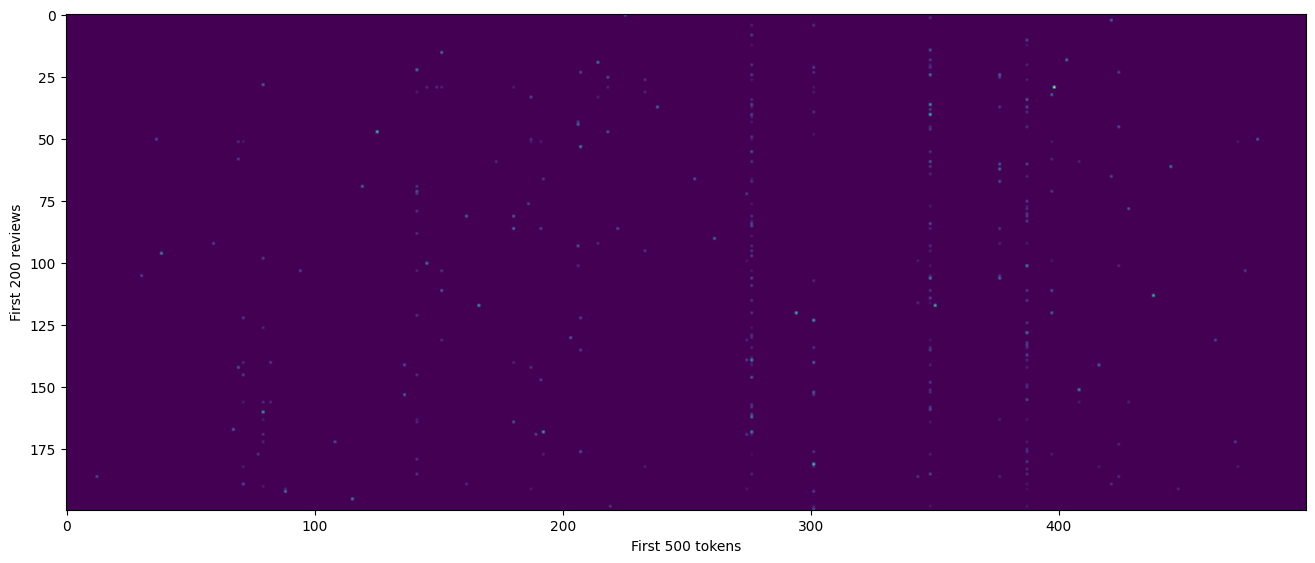

In [35]:
plt.figure(figsize=(16, 16))
plt.imshow(reviews_tfidf.tocsr()[:200,:500].todense().A)
plt.xlabel('First 500 tokens')
plt.ylabel('First 200 reviews')

In [36]:
f'{reviews_tfidf.data.nbytes / 1e6} Mb'

'34.045792 Mb'

## 2.9. Train-test split

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(reviews_tfidf, dataset['sentiment'].values.ravel(), test_size=0.1, random_state=42)

In [39]:
X_train

<45000x51965 sparse matrix of type '<class 'numpy.float64'>'
	with 3826010 stored elements in Compressed Sparse Row format>

# 3. Modeling 
## 3.1. Training Random Forest model and evaluation

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## 3.2. Evaluation

In [42]:
from sklearn.metrics import accuracy_score
y_pred_train = model.predict(X_train)
accuracy_score(y_train, y_pred_train)

1.0

In [43]:
y_pred_test = model.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.8534

In [44]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(data=confusion_matrix(y_true=y_test, y_pred=y_pred_test),
             columns=['predicted_negative', 'predicted_positive'],
             index=['real_negative', 'real_positive'])

,predicted_negative,predicted_positive
real_negative,2186,333
real_positive,400,2081


## 3.3. Hyperparameter search

In [45]:
from sklearn.model_selection import GridSearchCV

In [60]:
model = RandomForestClassifier()

params = {
    'n_estimators': [100, 300],
    'max_depth': [30, 60, 120],
    'min_samples_leaf': [2, 4, 8, 16],
}

grid_search = GridSearchCV(model, param_grid=params, scoring='accuracy', cv=4, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [30, 60, 120],
                         'min_samples_leaf': [2, 4, 8, 16],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=2)

[CV] END .max_depth=30, min_samples_leaf=2, n_estimators=300; total time= 1.9min
[CV] END .max_depth=30, min_samples_leaf=8, n_estimators=100; total time=  27.4s
[CV] END .max_depth=30, min_samples_leaf=8, n_estimators=300; total time= 1.6min
[CV] END .max_depth=60, min_samples_leaf=2, n_estimators=100; total time= 1.9min
[CV] END .max_depth=60, min_samples_leaf=4, n_estimators=100; total time= 1.3min
[CV] END .max_depth=60, min_samples_leaf=4, n_estimators=300; total time= 3.7min
[CV] END max_depth=60, min_samples_leaf=16, n_estimators=100; total time=  35.1s
[CV] END max_depth=60, min_samples_leaf=16, n_estimators=300; total time= 2.0min
[CV] END max_depth=120, min_samples_leaf=2, n_estimators=300; total time= 6.2min
[CV] END max_depth=120, min_samples_leaf=8, n_estimators=100; total time=  49.8s
[CV] END max_depth=120, min_samples_leaf=8, n_estimators=300; total time= 2.7min
[CV] END .max_depth=30, min_samples_leaf=2, n_estimators=100; total time=  36.8s
[CV] END .max_depth=30, min_

In [61]:
model = grid_search.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(model.get_params())
print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 120, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ACC train set: 0.9912444444444445
ACC test set: 0.863


## 3.4. Creating classifier Pipeline

In [62]:
from sklearn.pipeline import Pipeline

In [63]:
classifier_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=2, max_df=0.3)),
    ('classifier', RandomForestClassifier(**model.get_params()))
])

In [64]:
classifier_pipeline.fit(cleaned_reviews,
                        dataset['sentiment'].values.ravel())

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.3, min_df=2)),
                ('classifier',
                 RandomForestClassifier(max_depth=120, min_samples_leaf=2,
                                        n_estimators=300))])

In [65]:
raw_samples = ['This was the best movie i have ever seen. It should be in every cinema! I love it! :P ',
              'Terrible stuff, i cant say its good, what a waste of time... 0/10']
cleaned_samples = text_cleaner.transform(raw_samples)
classifier_pipeline.predict_proba(raw_samples)

array([[0.82817448, 0.17182552],
       [0.63234835, 0.36765165]])

In [66]:
import joblib

joblib.dump(classifier_pipeline, 'classifier_pipeline.pkl')

['classifier_pipeline.pkl']

In [70]:
classifier_pipeline_restored = joblib.load('classifier_pipeline.pkl')

classifier_pipeline_restored.predict_proba(raw_samples)

array([[0.82817448, 0.17182552],
       [0.63234835, 0.36765165]])